# Monotonized Fully-Connected network with MNIST

## Imports

In [1]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.utils.data as torch_data
from sklearn.metrics import accuracy_score
from torch.autograd import Variable

## Creating Dataset

In [2]:
# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]

input_size = 8*8
classes_n = 10
EPOCHS = 200

train_batch_size = 30 
val_batch_size = 100

In [3]:
class MNISTData(torch_data.Dataset):
    def __init__(self, X, y):
        super(MNISTData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return (self.X[idx],self.y[idx])

In [4]:
train_dset = MNISTData(digits_train, targets_train) 
val_dset = MNISTData(digits_test, targets_test) 
train_loader = torch_data.DataLoader(train_dset, batch_size=train_batch_size, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=val_batch_size, shuffle=False) 

## Creating model

In [5]:
class FCN(nn.Module):

    def __init__(self):
        super(FCN, self).__init__()
        self.fc0 = nn.Linear(64, 40)
        self.fc1 = nn.Linear(40, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, input_):
        h1 = F.relu(self.fc0(input_))
        h2 = F.relu(self.fc1(h1))
        h3 = self.fc2(h2)
        return h3


## Defining training procedure

In [6]:
def report_sparcity(model, layers=[0,1], verbose=0):
    zero_total = 0
    n_total = 0
    for layer_name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer,nn.Linear):
            zeros = (layer.weight.data == 0).sum().cpu().numpy()
            n = np.prod(layer.weight.data.shape)
            zero_total += zeros
            n_total += n

        if verbose > 0:
            print(f'Layer: {l}, 0-weights ratio: {zeros/n:.4}')

    return zero_total/n_total

In [7]:
def get_accuracy(net, dataloader):
    test_loader = torch_data.DataLoader(val_dset,batch_size = len(val_dset)) 
    net.eval()
    for X,y in dataloader:
        #X = X.to(device)
        nn_outputs = net(X).detach().numpy().argmax(axis = 1)
        return accuracy_score(nn_outputs,y.detach().numpy())

In [8]:
def monotonize(model, pos=True, ignore_last=True):
    for n, x in model.named_parameters():
        if 'weight' in n:
            if ignore_last and n == 'fc2.weight':
                continue
            attrs = n.split('.')
            obj = model
            for attr in attrs[:-1]:
                obj = getattr(obj, attr)

        if pos:
            obj.weight.data = obj.weight.clip(min=0)
        else:
            obj.weight.data = obj.weight.clip(max=0)

In [9]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True,
          save_dir=None, monotonize = None, L1_lambda = 0.01):
    if monotonize is not None:
        monotonize(net)
        if L1_lambda:
            print('Monotonized with l1')
        else:
            print('Monotonized')
    else:
        if not L1_lambda:
            print("Not monotonized")
    
    net.to(device)
    total_loss, accuracy_train, accuracy_test, sparsity = [], [], [], []
    for epoch in range(1, epochs+1):
        net.train()
        loss = []
        for X, y in train_loader:
            nn_outputs = net(X)
            loss1 = criterion(nn_outputs, y)
            optimizer.zero_grad()
            if L1_lambda:
                for name, param in net.named_parameters():
                    if 'weight' in name:
                        L1 = Variable(param, requires_grad=True)
                        L1 = torch.norm(L1, 1)
                        L1 = L1_lambda * L1
                        loss1 = loss1 + L1
            loss1.backward()
            loss.append(loss1.item())
            optimizer.step()
            if monotonize is not None:
                monotonize(net)
            

        net.eval()
        
        val_loss = []
        for X, y in val_loader:
            nn_outputs = net(X)
            val_loss1 = criterion(nn_outputs,y)
            val_loss.append(val_loss1.item())
        
        total_loss.append(np.mean(loss))
        
        acc_tr = get_accuracy(net, train_loader)
        acc_va = get_accuracy(net, val_loader)
        
        accuracy_train.append(acc_tr)
        accuracy_test.append(acc_va)
        
        spars = report_sparcity(net)
        sparsity.append(spars)
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} \t || Loss:  Train {:.3f} | Val {:.3f} || Accuracy: Train {:.3f} | Val {:.3f}\
 || Sparsity: {:.3f} '.format(epoch, epochs, np.mean(loss), np.mean(val_loss),acc_tr ,acc_va, spars ))

            
    return total_loss, accuracy_train, accuracy_test, sparsity

In [10]:
def show_results(loss, train, val, sp):
    _, ax = plt.subplots(1, 2, figsize=(20, 4))

    ax[0].plot(range(1, len(loss)+1), loss)
    ax[0].set_title('Loss', fontsize=14)

    ax[1].plot(range(1, len(train)+1), train, label='train')
    ax[1].plot(range(1, len(train)+1), val, label='validation')
    ax[1].set_title('Accuracy', fontsize=14)
    ax[1].set_xlabel('epoch', fontsize=14)
    ax[1].legend();
    plt.show()

    plt.plot(sp)
    plt.title('Model sparsity (0-weights ratio)');

## Testing models

In [11]:
device = 'cpu'

net = FCN() 
criterion = F.cross_entropy
optimizer = torch.optim.Adam(net.parameters())
scheduler = None
net_res = train(EPOCHS, net, criterion, optimizer, train_loader, val_loader, scheduler, monotonize=None, L1_lambda=0.000)
#%time show_results(*train(EPOCHS, net, criterion, optimizer, train_loader, val_loader, scheduler, monotonize=None, L1_lambda=0.000))

Not monotonized
Epoch 10/200 	 || Loss:  Train 1.587 | Val 1.579 || Accuracy: Train 0.433 | Val 0.460 || Sparsity: 0.000 
Epoch 20/200 	 || Loss:  Train 0.745 | Val 0.750 || Accuracy: Train 0.800 | Val 0.870 || Sparsity: 0.000 
Epoch 30/200 	 || Loss:  Train 0.453 | Val 0.457 || Accuracy: Train 0.833 | Val 0.930 || Sparsity: 0.000 
Epoch 40/200 	 || Loss:  Train 0.354 | Val 0.360 || Accuracy: Train 1.000 | Val 0.940 || Sparsity: 0.000 
Epoch 50/200 	 || Loss:  Train 0.297 | Val 0.311 || Accuracy: Train 0.867 | Val 0.950 || Sparsity: 0.000 
Epoch 60/200 	 || Loss:  Train 0.261 | Val 0.282 || Accuracy: Train 0.933 | Val 0.950 || Sparsity: 0.000 
Epoch 70/200 	 || Loss:  Train 0.232 | Val 0.258 || Accuracy: Train 0.900 | Val 0.950 || Sparsity: 0.000 
Epoch 80/200 	 || Loss:  Train 0.209 | Val 0.249 || Accuracy: Train 0.933 | Val 0.950 || Sparsity: 0.000 
Epoch 90/200 	 || Loss:  Train 0.188 | Val 0.242 || Accuracy: Train 0.933 | Val 0.940 || Sparsity: 0.000 
Epoch 100/200 	 || Loss:  Trai

In [12]:
device = 'cpu'

net_mon = FCN() 
criterion = F.cross_entropy
optimizer = torch.optim.Adam(net_mon.parameters())
scheduler = None
net_mon_res = train(EPOCHS, net_mon, criterion, optimizer, train_loader, val_loader, scheduler, monotonize=monotonize, L1_lambda=0.000)
#%time show_results(*train(EPOCHS, net_mon, criterion, optimizer, train_loader, val_loader, scheduler, monotonize=monotonize, L1_lambda=0.000))

Monotonized
Epoch 10/200 	 || Loss:  Train 1.926 | Val 1.911 || Accuracy: Train 0.500 | Val 0.410 || Sparsity: 0.412 
Epoch 20/200 	 || Loss:  Train 1.119 | Val 1.168 || Accuracy: Train 0.667 | Val 0.660 || Sparsity: 0.406 
Epoch 30/200 	 || Loss:  Train 0.921 | Val 0.979 || Accuracy: Train 0.733 | Val 0.680 || Sparsity: 0.341 
Epoch 40/200 	 || Loss:  Train 0.780 | Val 0.822 || Accuracy: Train 0.733 | Val 0.800 || Sparsity: 0.332 
Epoch 50/200 	 || Loss:  Train 0.637 | Val 0.671 || Accuracy: Train 0.900 | Val 0.870 || Sparsity: 0.297 
Epoch 60/200 	 || Loss:  Train 0.520 | Val 0.551 || Accuracy: Train 0.867 | Val 0.900 || Sparsity: 0.285 
Epoch 70/200 	 || Loss:  Train 0.442 | Val 0.470 || Accuracy: Train 0.800 | Val 0.900 || Sparsity: 0.316 
Epoch 80/200 	 || Loss:  Train 0.384 | Val 0.414 || Accuracy: Train 0.867 | Val 0.930 || Sparsity: 0.285 
Epoch 90/200 	 || Loss:  Train 0.335 | Val 0.366 || Accuracy: Train 0.933 | Val 0.910 || Sparsity: 0.289 
Epoch 100/200 	 || Loss:  Train 0.

In [13]:
device = 'cpu'

net_mon_l1 = FCN() 
criterion = F.cross_entropy
optimizer = torch.optim.Adam(net_mon_l1.parameters())
scheduler = None
net_mon_l1_res = train(EPOCHS, net_mon_l1, criterion, optimizer, train_loader, val_loader, scheduler, monotonize=monotonize, L1_lambda=0.0001)
#%time show_results(*train(EPOCHS, net_mon_l1, criterion, optimizer, train_loader, val_loader, scheduler, monotonize=monotonize, L1_lambda=0.0001))

Monotonized with l1
Epoch 10/200 	 || Loss:  Train 2.004 | Val 2.003 || Accuracy: Train 0.167 | Val 0.260 || Sparsity: 0.423 
Epoch 20/200 	 || Loss:  Train 1.442 | Val 1.392 || Accuracy: Train 0.533 | Val 0.600 || Sparsity: 0.402 
Epoch 30/200 	 || Loss:  Train 0.946 | Val 0.910 || Accuracy: Train 0.767 | Val 0.750 || Sparsity: 0.382 
Epoch 40/200 	 || Loss:  Train 0.788 | Val 0.733 || Accuracy: Train 0.800 | Val 0.810 || Sparsity: 0.344 
Epoch 50/200 	 || Loss:  Train 0.709 | Val 0.653 || Accuracy: Train 0.767 | Val 0.820 || Sparsity: 0.362 
Epoch 60/200 	 || Loss:  Train 0.657 | Val 0.588 || Accuracy: Train 0.800 | Val 0.840 || Sparsity: 0.341 
Epoch 70/200 	 || Loss:  Train 0.623 | Val 0.542 || Accuracy: Train 0.800 | Val 0.840 || Sparsity: 0.296 
Epoch 80/200 	 || Loss:  Train 0.584 | Val 0.506 || Accuracy: Train 0.800 | Val 0.890 || Sparsity: 0.369 
Epoch 90/200 	 || Loss:  Train 0.555 | Val 0.477 || Accuracy: Train 0.900 | Val 0.880 || Sparsity: 0.313 
Epoch 100/200 	 || Loss:  

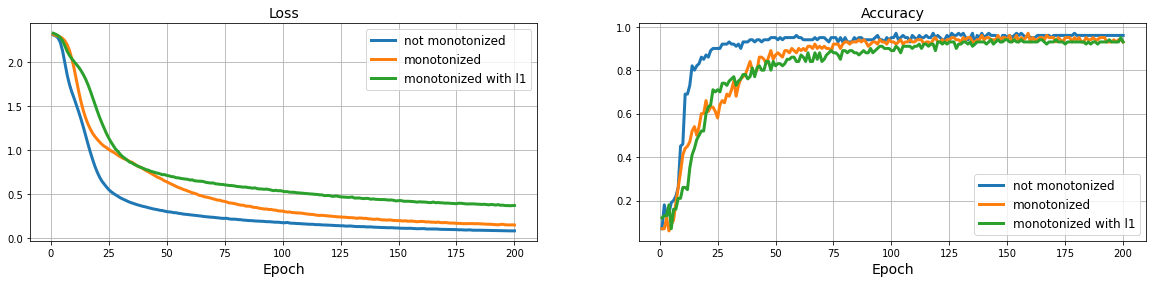

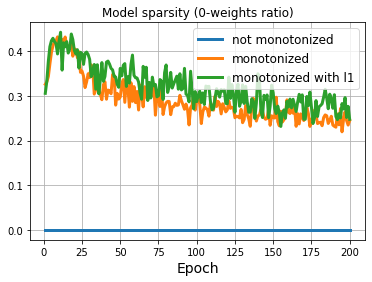

In [14]:
loss, train, val, sp = net_res
loss1, train1, val1, sp1 = net_mon_res
loss2, train2, val2, sp2 = net_mon_l1_res
_, ax = plt.subplots(1, 2, figsize=(20, 4))

ax[0].plot(range(1, len(loss)+1), loss, label='not monotonized', lw=3)
ax[0].plot(range(1, len(loss1)+1), loss1, label='monotonized', lw=3)
ax[0].plot(range(1, len(loss2)+1), loss2, label='monotonized with l1', lw=3)
ax[0].set_title('Loss', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].legend(fontsize=12)
ax[0].grid()

ax[1].plot(range(1, len(train)+1), val, label='not monotonized', lw=3)
ax[1].plot(range(1, len(train)+1), val1, label='monotonized', lw=3)
ax[1].plot(range(1, len(train)+1), val2, label='monotonized with l1', lw=3)

ax[1].set_title('Accuracy', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].legend(fontsize=12, loc='lower right');
ax[1].grid()
plt.show()

plt.plot(range(1, len(sp)+1), sp, label='not monotonized', lw=3)
plt.plot(range(1, len(sp1)+1), sp1, label='monotonized', lw=3)
plt.plot(range(1, len(sp2)+1), sp2, label='monotonized with l1', lw=3)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.title('Model sparsity (0-weights ratio)');

## Sanity check

In [15]:
nets = [net, net_mon, net_mon_l1]

def generate_monotone_sequence(example):
    n_features = example.shape[1]
    seq = np.arange(100 * n_features).reshape(100, n_features)

    return torch.tensor(seq, dtype=example.dtype)

def check_monotonicity(self, input, output):
    for i in range(input[0].shape[1]):
        res = input[0][:, i].detach().numpy()
        print(f'Neuron #{i} \t (the last layer) has monotone input: {np.all(np.diff(res) >= 0)}')
        
seq = generate_monotone_sequence(train_dset.X) / 6400.

handle = nets[1].fc2.register_forward_hook(check_monotonicity)

_ = nets[1](seq)

handle.remove()

Neuron #0 	 (the last layer) has monotone input: True
Neuron #1 	 (the last layer) has monotone input: True
Neuron #2 	 (the last layer) has monotone input: True
Neuron #3 	 (the last layer) has monotone input: True
Neuron #4 	 (the last layer) has monotone input: True
Neuron #5 	 (the last layer) has monotone input: True
Neuron #6 	 (the last layer) has monotone input: True
Neuron #7 	 (the last layer) has monotone input: True
Neuron #8 	 (the last layer) has monotone input: True
Neuron #9 	 (the last layer) has monotone input: True
Neuron #10 	 (the last layer) has monotone input: True
Neuron #11 	 (the last layer) has monotone input: True
Neuron #12 	 (the last layer) has monotone input: True
Neuron #13 	 (the last layer) has monotone input: True
Neuron #14 	 (the last layer) has monotone input: True
Neuron #15 	 (the last layer) has monotone input: True
Neuron #16 	 (the last layer) has monotone input: True
Neuron #17 	 (the last layer) has monotone input: True
Neuron #18 	 (the la

In [16]:
seq2 = generate_monotone_sequence(train_dset.X) / 6400.

handle = nets[2].fc2.register_forward_hook(check_monotonicity)

_ = nets[2](seq)

handle.remove()

Neuron #0 	 (the last layer) has monotone input: True
Neuron #1 	 (the last layer) has monotone input: True
Neuron #2 	 (the last layer) has monotone input: True
Neuron #3 	 (the last layer) has monotone input: True
Neuron #4 	 (the last layer) has monotone input: True
Neuron #5 	 (the last layer) has monotone input: True
Neuron #6 	 (the last layer) has monotone input: True
Neuron #7 	 (the last layer) has monotone input: True
Neuron #8 	 (the last layer) has monotone input: True
Neuron #9 	 (the last layer) has monotone input: True
Neuron #10 	 (the last layer) has monotone input: True
Neuron #11 	 (the last layer) has monotone input: True
Neuron #12 	 (the last layer) has monotone input: True
Neuron #13 	 (the last layer) has monotone input: True
Neuron #14 	 (the last layer) has monotone input: True
Neuron #15 	 (the last layer) has monotone input: True
Neuron #16 	 (the last layer) has monotone input: True
Neuron #17 	 (the last layer) has monotone input: True
Neuron #18 	 (the la